In [1]:
import sys
sys.path.append("C:\Python312\Lib\site-packages")
import pandas as pd
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

input_train_data = pd.read_csv("C:/Users/supri/OneDrive/projects/credit_fraud_raw/fraudTrain.csv")
input_test_data = pd.read_csv("C:/Users/supri/OneDrive/projects/credit_fraud_raw/fraudTest.csv")

train_data = input_train_data.sample(n=100000, random_state=42)
test_data = input_test_data.sample(n=50000, random_state=42)


In [2]:
train_data.info()
train_data.describe()
train_data.dtypes
train_data.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1045211 to 1049499
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   trans_date_trans_time  100000 non-null  object 
 2   cc_num                 100000 non-null  int64  
 3   merchant               100000 non-null  object 
 4   category               100000 non-null  object 
 5   amt                    100000 non-null  float64
 6   first                  100000 non-null  object 
 7   last                   100000 non-null  object 
 8   gender                 100000 non-null  object 
 9   street                 100000 non-null  object 
 10  city                   100000 non-null  object 
 11  state                  100000 non-null  object 
 12  zip                    100000 non-null  int64  
 13  lat                    100000 non-null  float64
 14  long                   100000

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [3]:
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1045211,1045211,2020-03-09 15:09:26,577588686219,fraud_Towne LLC,misc_pos,194.51,James,Strickland,M,25454 Leonard Lake,...,40.6153,-79.4545,972,Public relations account executive,1997-10-23,fff87d4340ef756a592eac652493cf6b,1362841766,40.420453,-78.865012,0
547406,547406,2019-08-22 15:49:01,30376238035123,fraud_Friesen Ltd,health_fitness,52.32,Cynthia,Davis,F,7177 Steven Forges,...,42.8250,-124.4409,217,Retail merchandiser,1928-10-01,d0ad335af432f35578eea01d639b3621,1345650541,42.758860,-123.636337,0
110142,110142,2019-03-04 01:34:16,4658490815480264,fraud_Mohr Inc,shopping_pos,6.53,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,87f26e3ea33f4ff4c7a8bad2c7f48686,1330824856,40.475159,-78.898190,0
1285953,1285953,2020-06-16 20:04:38,3514897282719543,fraud_Gaylord-Powlowski,home,7.33,Steven,Faulkner,M,841 Cheryl Centers Suite 115,...,42.9580,-77.3083,10717,Cytogeneticist,1952-10-13,9c34015321c0fa2ae6fd20f9359d1d3e,1371413078,43.767506,-76.542384,0
271705,271705,2019-05-14 05:54:48,6011381817520024,"fraud_Christiansen, Goyette and Schamberger",gas_transport,64.29,Kristen,Allen,F,8619 Lisa Manors Apt. 871,...,41.6423,-104.1974,635,Product/process development scientist,1973-07-13,198437c05676f485e9be04449c664475,1336974888,41.040392,-104.092324,0


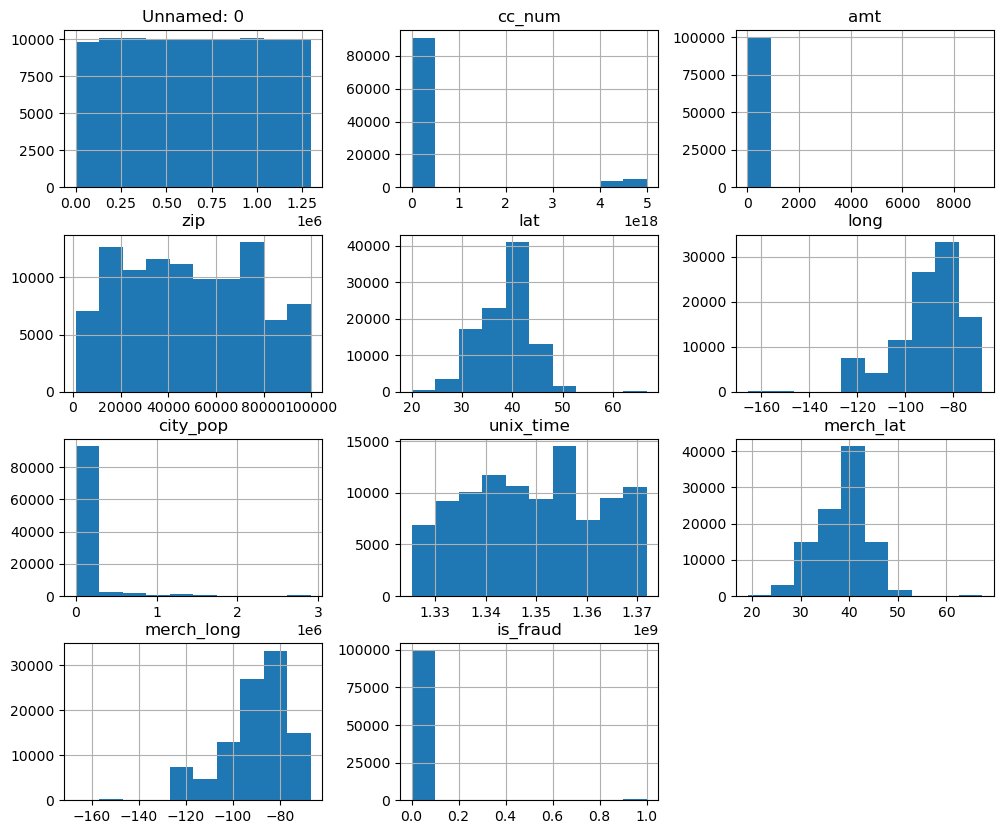

In [4]:
# Histograms for numerical features
train_data.hist(figsize=(12, 10))
plt.show()

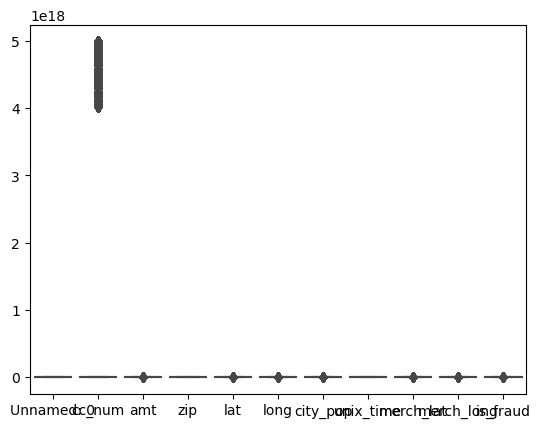

In [5]:
# Box plot for numerical features
sns.boxplot(data=train_data)
plt.show()

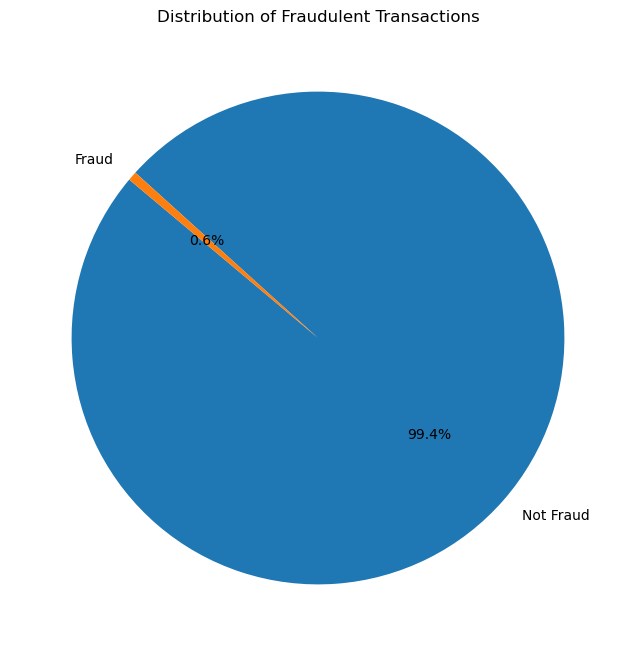

In [6]:
# Pie chart for categorical features
plt.figure(figsize=(8, 8))
fraud_counts = train_data['is_fraud'].value_counts()
labels = ['Not Fraud', 'Fraud']
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraudulent Transactions')
plt.show()


C:\Users\supri\AppData\Local\Temp\ipykernel_23652\1004653597.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')


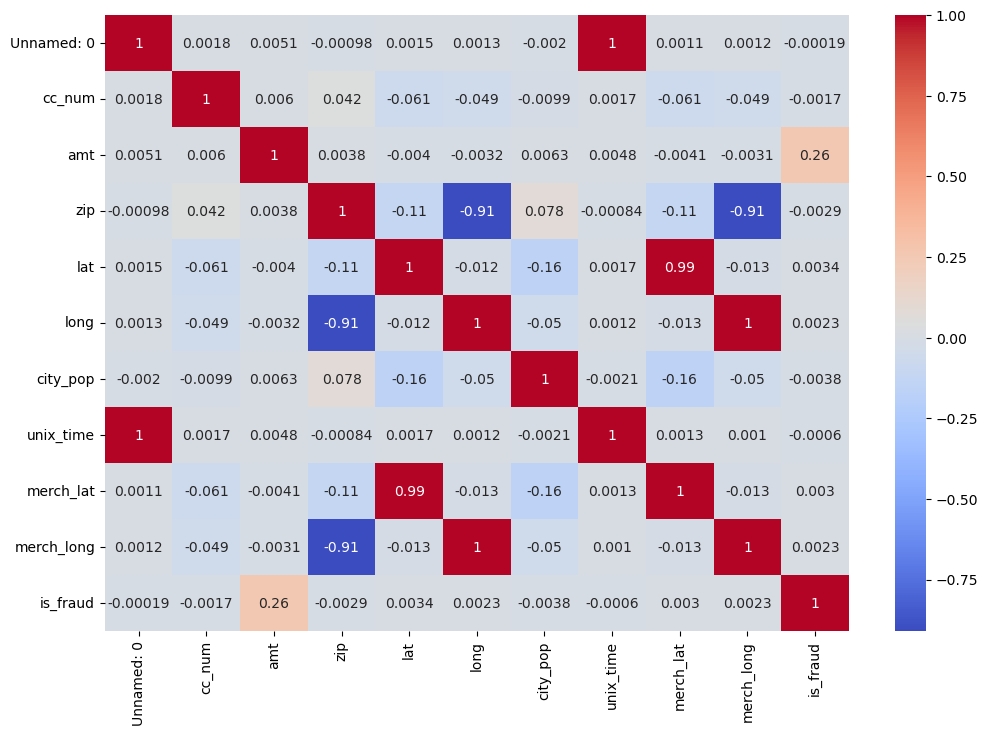

In [7]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [8]:
train_data.drop(columns=['Unnamed: 0','first', 'last', 'street', 'zip','city', 'state', 'trans_num'], inplace=True)
test_data.drop(columns=['Unnamed: 0','first', 'last', 'street', 'zip','city', 'state', 'trans_num'], inplace=True)

In [9]:
# Convert the 'trans_date_trans_time' column to datetime
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['dob'] = pd.to_datetime(train_data['dob'])
# Convert the 'trans_date_trans_time' column to datetime
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])
test_data['dob'] = pd.to_datetime(test_data['dob'])

# Calculate age at the time of transaction
train_data['age'] = train_data['trans_date_trans_time'].dt.year - train_data['dob'].dt.year - ((train_data['trans_date_trans_time'].dt.month < train_data['dob'].dt.month) | ((train_data['trans_date_trans_time'].dt.month == train_data['dob'].dt.month) & (train_data['trans_date_trans_time'].dt.day < train_data['dob'].dt.day)))
# Calculate age at the time of transaction
test_data['age'] = test_data['trans_date_trans_time'].dt.year - test_data['dob'].dt.year - ((test_data['trans_date_trans_time'].dt.month < test_data['dob'].dt.month) | ((test_data['trans_date_trans_time'].dt.month == test_data['dob'].dt.month) & (test_data['trans_date_trans_time'].dt.day < test_data['dob'].dt.day)))

# Drop the 'dob' column as it's no longer needed
train_data.drop(columns=['dob'], inplace=True)
# Drop the 'dob' column as it's no longer needed
test_data.drop(columns=['dob'], inplace=True)

# Extract numerical features from the datetime if needed
train_data['year'] = train_data['trans_date_trans_time'].dt.year
train_data['month'] = train_data['trans_date_trans_time'].dt.month
train_data['day'] = train_data['trans_date_trans_time'].dt.day
train_data['hour'] = train_data['trans_date_trans_time'].dt.hour
train_data['minute'] = train_data['trans_date_trans_time'].dt.minute
train_data['second'] = train_data['trans_date_trans_time'].dt.second
# Extract numerical features from the datetime if needed
test_data['year'] = test_data['trans_date_trans_time'].dt.year
test_data['month'] = test_data['trans_date_trans_time'].dt.month
test_data['day'] = test_data['trans_date_trans_time'].dt.day
test_data['hour'] = test_data['trans_date_trans_time'].dt.hour
test_data['minute'] = test_data['trans_date_trans_time'].dt.minute
test_data['second'] = test_data['trans_date_trans_time'].dt.second

# Drop the original datetime column
train_data.drop(columns=['trans_date_trans_time'], inplace=True)
# Drop the original datetime column
test_data.drop(columns=['trans_date_trans_time'], inplace=True)




In [10]:
# Separate the target variable
X_train = train_data.drop(columns=['is_fraud'])
y_train = train_data['is_fraud']

X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

In [11]:
target_encode_features = ['merchant', 'category', 'gender', 'job']
# Initialize the target encoder
target_enc = ce.TargetEncoder(cols=target_encode_features)

# Fit the encoder on the training data and transform both training and test data
X_train[target_encode_features] = target_enc.fit_transform(X_train[target_encode_features], y_train)
X_test[target_encode_features] = target_enc.transform(X_test[target_encode_features])

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Train the SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9967
Precision: 0.96875
Recall: 0.15897435897435896
F1 Score: 0.27312775330396477


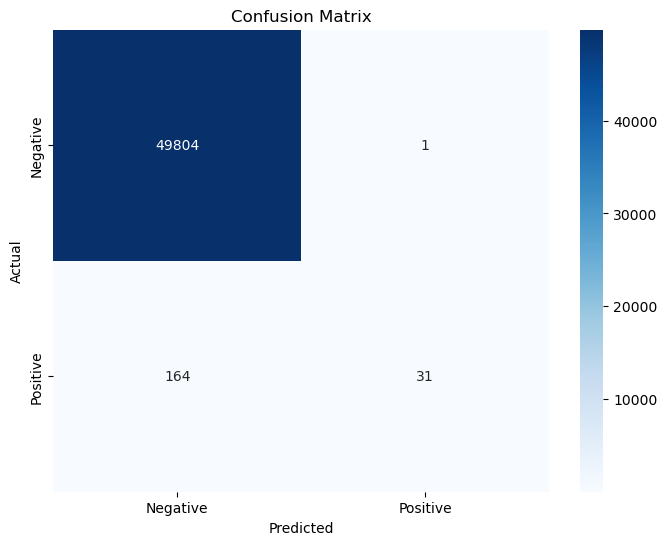

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.997
Precision: 0.9245283018867925
Recall: 0.2512820512820513
F1 Score: 0.3951612903225806


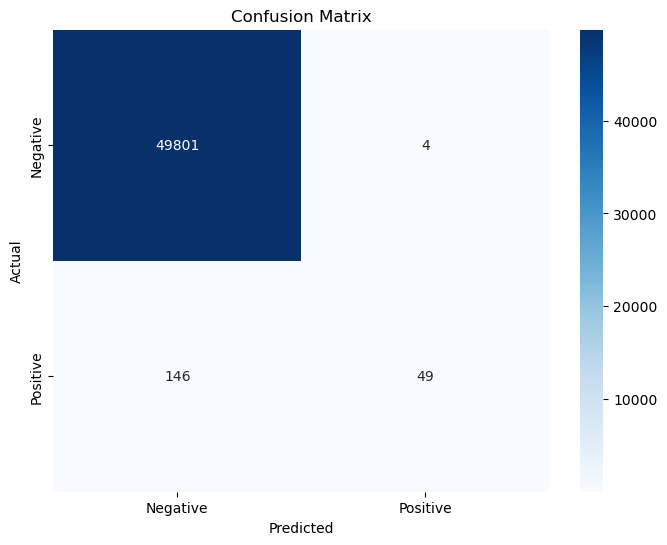

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Assuming X_train and y_train are already defined and preprocessed

# Create and train the LightGBM classifier
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_lgbm = lgbm_clf.predict(X_test)

# Evaluate the model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

print("Accuracy:", accuracy_lgbm)
print("Precision:", precision_lgbm)
print("F1 Score:", f1_lgbm)


[LightGBM] [Info] Number of positive: 598, number of negative: 99402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005980 -> initscore=-5.113337
[LightGBM] [Info] Start training from score -5.113337
Accuracy: 0.99708
Precision: 0.696
F1 Score: 0.54375


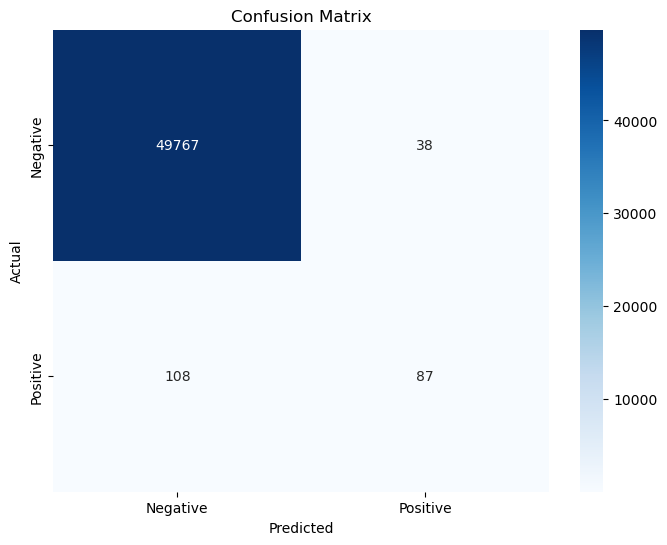

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, f1_score


# Counting the number of positive and negative samples in the training data
num_positive = sum(y_train == 1)
num_negative = sum(y_train == 0)

# Calculating the ratio of positive to negative samples
scale_pos_weight = num_negative / num_positive

# Defining the XGBoost model with scale_pos_weight parameter
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred_xgboost = model.predict(X_test)

# Calculating evaluation metrics
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
precision_xgboost = precision_score(y_test, y_pred_xgboost)
f1_xgboost = f1_score(y_test, y_pred_xgboost)

print("Accuracy:", accuracy_xgboost)
print("Precision:", precision_xgboost)
print("F1 Score:", f1_xgboost)


Accuracy: 0.996
Precision: 0.48520710059171596
F1 Score: 0.45054945054945056


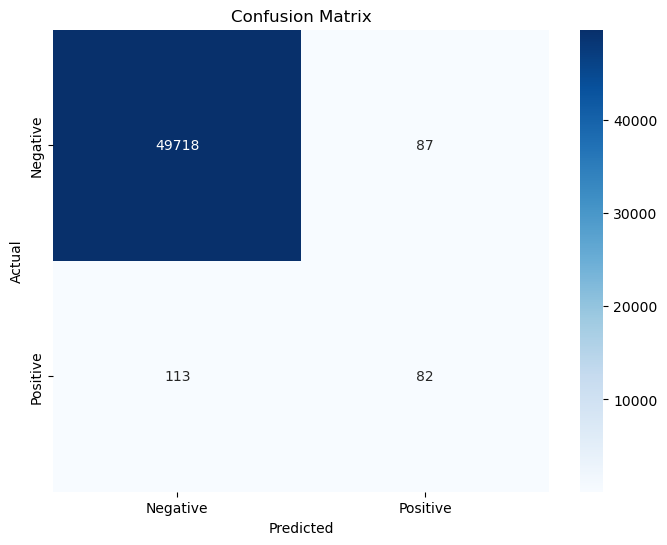

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred_xgboost)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Train the CatBoost classifier
catboost_clf = CatBoostClassifier()
catboost_clf.fit(X_train, y_train)
y_pred_catboost = catboost_clf.predict(X_test)

# Evaluate the CatBoost classifier
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)

print("Accuracy:", accuracy_catboost)
print("Precision:", precision_catboost)
print("F1 Score:", f1_catboost)

Learning rate set to 0.07361
0:	learn: 0.4808505	total: 233ms	remaining: 3m 52s
1:	learn: 0.3610614	total: 272ms	remaining: 2m 15s
2:	learn: 0.2394419	total: 309ms	remaining: 1m 42s
3:	learn: 0.1634398	total: 344ms	remaining: 1m 25s
4:	learn: 0.1191344	total: 369ms	remaining: 1m 13s
5:	learn: 0.0874171	total: 388ms	remaining: 1m 4s
6:	learn: 0.0641416	total: 405ms	remaining: 57.5s
7:	learn: 0.0494251	total: 423ms	remaining: 52.4s
8:	learn: 0.0387541	total: 440ms	remaining: 48.5s
9:	learn: 0.0320810	total: 458ms	remaining: 45.3s
10:	learn: 0.0271183	total: 475ms	remaining: 42.7s
11:	learn: 0.0234441	total: 493ms	remaining: 40.6s
12:	learn: 0.0208410	total: 510ms	remaining: 38.8s
13:	learn: 0.0190524	total: 527ms	remaining: 37.1s
14:	learn: 0.0176378	total: 545ms	remaining: 35.8s
15:	learn: 0.0168755	total: 563ms	remaining: 34.6s
16:	learn: 0.0158931	total: 580ms	remaining: 33.6s
17:	learn: 0.0154978	total: 598ms	remaining: 32.6s
18:	learn: 0.0150940	total: 614ms	remaining: 31.7s
19:	lea

162:	learn: 0.0037501	total: 3.11s	remaining: 16s
163:	learn: 0.0037362	total: 3.13s	remaining: 15.9s
164:	learn: 0.0037327	total: 3.14s	remaining: 15.9s
165:	learn: 0.0036954	total: 3.16s	remaining: 15.9s
166:	learn: 0.0036783	total: 3.18s	remaining: 15.9s
167:	learn: 0.0036669	total: 3.2s	remaining: 15.9s
168:	learn: 0.0036638	total: 3.22s	remaining: 15.8s
169:	learn: 0.0036489	total: 3.24s	remaining: 15.8s
170:	learn: 0.0036291	total: 3.26s	remaining: 15.8s
171:	learn: 0.0036165	total: 3.28s	remaining: 15.8s
172:	learn: 0.0036034	total: 3.29s	remaining: 15.7s
173:	learn: 0.0035988	total: 3.31s	remaining: 15.7s
174:	learn: 0.0035913	total: 3.33s	remaining: 15.7s
175:	learn: 0.0035845	total: 3.35s	remaining: 15.7s
176:	learn: 0.0035714	total: 3.37s	remaining: 15.7s
177:	learn: 0.0035376	total: 3.39s	remaining: 15.7s
178:	learn: 0.0035235	total: 3.41s	remaining: 15.6s
179:	learn: 0.0035114	total: 3.43s	remaining: 15.6s
180:	learn: 0.0034868	total: 3.45s	remaining: 15.6s
181:	learn: 0.0

327:	learn: 0.0023214	total: 6.16s	remaining: 12.6s
328:	learn: 0.0023135	total: 6.17s	remaining: 12.6s
329:	learn: 0.0023070	total: 6.19s	remaining: 12.6s
330:	learn: 0.0023038	total: 6.21s	remaining: 12.6s
331:	learn: 0.0023004	total: 6.23s	remaining: 12.5s
332:	learn: 0.0022976	total: 6.25s	remaining: 12.5s
333:	learn: 0.0022967	total: 6.26s	remaining: 12.5s
334:	learn: 0.0022940	total: 6.28s	remaining: 12.5s
335:	learn: 0.0022797	total: 6.3s	remaining: 12.5s
336:	learn: 0.0022779	total: 6.32s	remaining: 12.4s
337:	learn: 0.0022604	total: 6.34s	remaining: 12.4s
338:	learn: 0.0022490	total: 6.36s	remaining: 12.4s
339:	learn: 0.0022469	total: 6.38s	remaining: 12.4s
340:	learn: 0.0022436	total: 6.39s	remaining: 12.4s
341:	learn: 0.0022273	total: 6.41s	remaining: 12.3s
342:	learn: 0.0022183	total: 6.43s	remaining: 12.3s
343:	learn: 0.0022099	total: 6.45s	remaining: 12.3s
344:	learn: 0.0022048	total: 6.46s	remaining: 12.3s
345:	learn: 0.0022017	total: 6.48s	remaining: 12.3s
346:	learn: 0

488:	learn: 0.0015568	total: 9.05s	remaining: 9.46s
489:	learn: 0.0015512	total: 9.07s	remaining: 9.44s
490:	learn: 0.0015479	total: 9.09s	remaining: 9.42s
491:	learn: 0.0015455	total: 9.1s	remaining: 9.4s
492:	learn: 0.0015449	total: 9.12s	remaining: 9.38s
493:	learn: 0.0015422	total: 9.14s	remaining: 9.36s
494:	learn: 0.0015373	total: 9.15s	remaining: 9.34s
495:	learn: 0.0015349	total: 9.17s	remaining: 9.32s
496:	learn: 0.0015291	total: 9.19s	remaining: 9.3s
497:	learn: 0.0015245	total: 9.21s	remaining: 9.28s
498:	learn: 0.0015205	total: 9.23s	remaining: 9.26s
499:	learn: 0.0015185	total: 9.24s	remaining: 9.24s
500:	learn: 0.0015161	total: 9.26s	remaining: 9.22s
501:	learn: 0.0015145	total: 9.28s	remaining: 9.21s
502:	learn: 0.0015054	total: 9.3s	remaining: 9.19s
503:	learn: 0.0015034	total: 9.31s	remaining: 9.17s
504:	learn: 0.0015013	total: 9.33s	remaining: 9.15s
505:	learn: 0.0014984	total: 9.35s	remaining: 9.13s
506:	learn: 0.0014966	total: 9.37s	remaining: 9.11s
507:	learn: 0.00

654:	learn: 0.0010667	total: 12.1s	remaining: 6.38s
655:	learn: 0.0010654	total: 12.1s	remaining: 6.36s
656:	learn: 0.0010620	total: 12.1s	remaining: 6.34s
657:	learn: 0.0010612	total: 12.2s	remaining: 6.32s
658:	learn: 0.0010575	total: 12.2s	remaining: 6.3s
659:	learn: 0.0010570	total: 12.2s	remaining: 6.28s
660:	learn: 0.0010540	total: 12.2s	remaining: 6.26s
661:	learn: 0.0010536	total: 12.2s	remaining: 6.25s
662:	learn: 0.0010527	total: 12.3s	remaining: 6.23s
663:	learn: 0.0010522	total: 12.3s	remaining: 6.21s
664:	learn: 0.0010510	total: 12.3s	remaining: 6.19s
665:	learn: 0.0010488	total: 12.3s	remaining: 6.17s
666:	learn: 0.0010432	total: 12.3s	remaining: 6.15s
667:	learn: 0.0010380	total: 12.3s	remaining: 6.13s
668:	learn: 0.0010363	total: 12.4s	remaining: 6.12s
669:	learn: 0.0010347	total: 12.4s	remaining: 6.1s
670:	learn: 0.0010335	total: 12.4s	remaining: 6.08s
671:	learn: 0.0010332	total: 12.4s	remaining: 6.06s
672:	learn: 0.0010275	total: 12.4s	remaining: 6.04s
673:	learn: 0.

823:	learn: 0.0007684	total: 15.1s	remaining: 3.23s
824:	learn: 0.0007672	total: 15.2s	remaining: 3.21s
825:	learn: 0.0007623	total: 15.2s	remaining: 3.2s
826:	learn: 0.0007605	total: 15.2s	remaining: 3.18s
827:	learn: 0.0007602	total: 15.2s	remaining: 3.16s
828:	learn: 0.0007598	total: 15.2s	remaining: 3.14s
829:	learn: 0.0007579	total: 15.2s	remaining: 3.12s
830:	learn: 0.0007574	total: 15.3s	remaining: 3.1s
831:	learn: 0.0007568	total: 15.3s	remaining: 3.08s
832:	learn: 0.0007560	total: 15.3s	remaining: 3.07s
833:	learn: 0.0007547	total: 15.3s	remaining: 3.05s
834:	learn: 0.0007497	total: 15.3s	remaining: 3.03s
835:	learn: 0.0007482	total: 15.4s	remaining: 3.01s
836:	learn: 0.0007479	total: 15.4s	remaining: 2.99s
837:	learn: 0.0007471	total: 15.4s	remaining: 2.98s
838:	learn: 0.0007434	total: 15.4s	remaining: 2.96s
839:	learn: 0.0007401	total: 15.4s	remaining: 2.94s
840:	learn: 0.0007395	total: 15.4s	remaining: 2.92s
841:	learn: 0.0007392	total: 15.5s	remaining: 2.9s
842:	learn: 0.0

982:	learn: 0.0005808	total: 18s	remaining: 312ms
983:	learn: 0.0005797	total: 18s	remaining: 293ms
984:	learn: 0.0005796	total: 18.1s	remaining: 275ms
985:	learn: 0.0005778	total: 18.1s	remaining: 257ms
986:	learn: 0.0005766	total: 18.1s	remaining: 238ms
987:	learn: 0.0005749	total: 18.1s	remaining: 220ms
988:	learn: 0.0005740	total: 18.1s	remaining: 202ms
989:	learn: 0.0005725	total: 18.1s	remaining: 183ms
990:	learn: 0.0005717	total: 18.2s	remaining: 165ms
991:	learn: 0.0005713	total: 18.2s	remaining: 147ms
992:	learn: 0.0005710	total: 18.2s	remaining: 128ms
993:	learn: 0.0005693	total: 18.2s	remaining: 110ms
994:	learn: 0.0005686	total: 18.2s	remaining: 91.7ms
995:	learn: 0.0005682	total: 18.3s	remaining: 73.3ms
996:	learn: 0.0005677	total: 18.3s	remaining: 55ms
997:	learn: 0.0005675	total: 18.3s	remaining: 36.7ms
998:	learn: 0.0005673	total: 18.3s	remaining: 18.3ms
999:	learn: 0.0005661	total: 18.3s	remaining: 0us
Accuracy: 0.99786
Precision: 0.860655737704918
F1 Score: 0.66246056

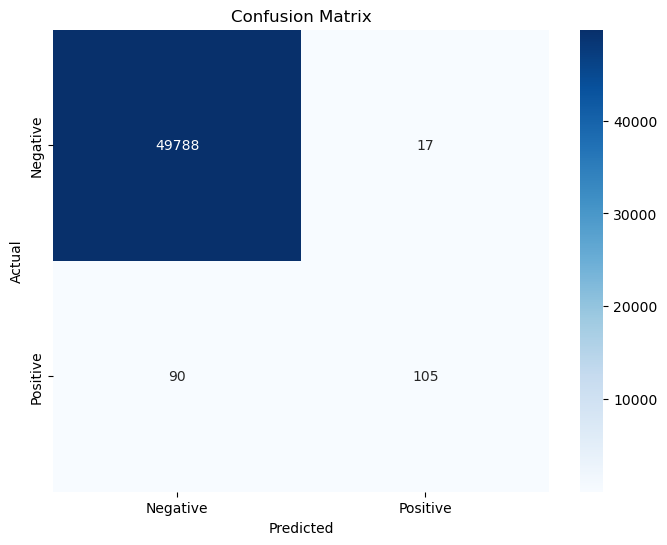

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred_catboost)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()